In [427]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [428]:
generation_df = pd.read_csv("data/Plant_2_Generation_Data.csv")

In [429]:
generation_df.tail()

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
67693,2020-06-17 23:45:00,4136001,q49J1IKaHRwDQnt,0.0,0.0,4157.0,520758.0
67694,2020-06-17 23:45:00,4136001,rrq4fwE8jgrTyWY,0.0,0.0,3931.0,121131356.0
67695,2020-06-17 23:45:00,4136001,vOuJvMaM2sgwLmb,0.0,0.0,4322.0,2427691.0
67696,2020-06-17 23:45:00,4136001,xMbIugepa2P7lBB,0.0,0.0,4218.0,106896394.0
67697,2020-06-17 23:45:00,4136001,xoJJ8DcxJEcupym,0.0,0.0,4316.0,209335741.0


In [430]:
weather_df = pd.read_csv("data/Plant_2_Weather_Sensor_Data.csv")

In [431]:
weather_df.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,4136001,iq8k7ZNt4Mwm3w0,27.004764,25.060789,0.0
1,2020-05-15 00:15:00,4136001,iq8k7ZNt4Mwm3w0,26.880811,24.421869,0.0
2,2020-05-15 00:30:00,4136001,iq8k7ZNt4Mwm3w0,26.682055,24.427290,0.0
3,2020-05-15 00:45:00,4136001,iq8k7ZNt4Mwm3w0,26.500589,24.420678,0.0
4,2020-05-15 01:00:00,4136001,iq8k7ZNt4Mwm3w0,26.596148,25.088210,0.0


In [432]:
 # Step 1: Group by timestamp and sum across inverters
generation_grouped = generation_df.groupby('DATE_TIME')[['DC_POWER', 'AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD']].sum()

# Step 2: Reindex to match the weather timestamps exactly
# This keeps missing timestamps and fills them with zeros
generation_grouped = generation_grouped.reindex(weather_df['DATE_TIME']).fillna(0)

# Step 3: Reset index to make DATE_TIME a column again
generation_grouped = generation_grouped.reset_index().rename(columns={'index': 'DATE_TIME'})

In [433]:
weather_df_idx = weather_df.set_index('DATE_TIME')
generation_idx = generation_grouped.set_index('DATE_TIME')

display(weather_df_idx.describe())
display(generation_idx.describe())

,PLANT_ID,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
count,3259.0,3259.000000,3259.000000,3259.000000
mean,4136001.0,28.069400,32.772408,0.232737
std,0.0,4.061556,11.344034,0.312693
min,4136001.0,20.942385,20.265123,0.000000
25%,4136001.0,24.602135,23.716881,0.000000
50%,4136001.0,26.981263,27.534606,0.019040
75%,4136001.0,31.056757,40.480653,0.438717
max,4136001.0,39.181638,66.635953,1.098766


,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
count,3259.000000,3259.000000,3259.000000,3.259000e+03
mean,5124.648465,5011.974903,68443.535809,1.368802e+10
std,6462.118509,6317.872611,48505.077129,1.245968e+09
min,0.000000,0.000000,0.000000,0.000000e+00
25%,0.000000,0.000000,18698.245238,1.335913e+10
50%,494.427143,477.536667,73875.000000,1.419016e+10
75%,11048.773333,10795.727619,110975.223810,1.419312e+10
max,26630.506667,25979.760476,162876.000000,1.419408e+10


In [434]:
weather_df_idx = weather_df_idx.drop(['PLANT_ID', 'SOURCE_KEY'], axis=1)
weather_df_idx.head()

,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
DATE_TIME,,,
2020-05-15 00:00:00,27.004764,25.060789,0.0
2020-05-15 00:15:00,26.880811,24.421869,0.0
2020-05-15 00:30:00,26.682055,24.427290,0.0
2020-05-15 00:45:00,26.500589,24.420678,0.0
2020-05-15 01:00:00,26.596148,25.088210,0.0


In [435]:
df = pd.merge(generation_idx, weather_df_idx, on='DATE_TIME')
df.head()

,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
DATE_TIME,,,,,,,
2020-05-15 00:00:00,0.0,0.0,48899.938095,1.418960e+10,27.004764,25.060789,0.0
2020-05-15 00:15:00,0.0,0.0,28401.000000,1.418960e+10,26.880811,24.421869,0.0
2020-05-15 00:30:00,0.0,0.0,28401.000000,1.418960e+10,26.682055,24.427290,0.0
2020-05-15 00:45:00,0.0,0.0,28401.000000,1.418960e+10,26.500589,24.420678,0.0
2020-05-15 01:00:00,0.0,0.0,26516.000000,1.418960e+10,26.596148,25.088210,0.0


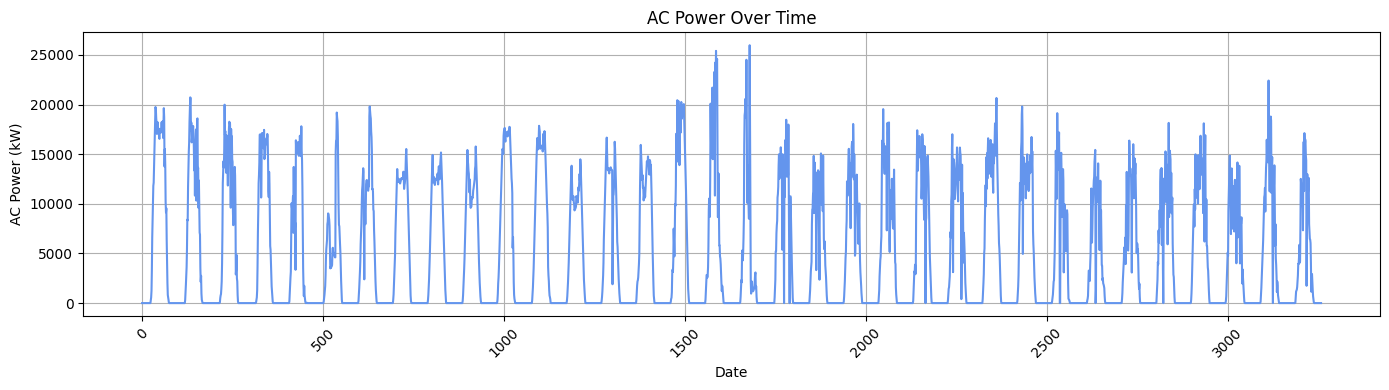

In [436]:
import numpy as np

plt.figure(figsize=(14, 4))
plt.plot(np.array(df['AC_POWER']),color="cornflowerblue")
plt.title('AC Power Over Time')
plt.xlabel('Date')
plt.ylabel('AC Power (kW)')
plt.grid(True)
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()

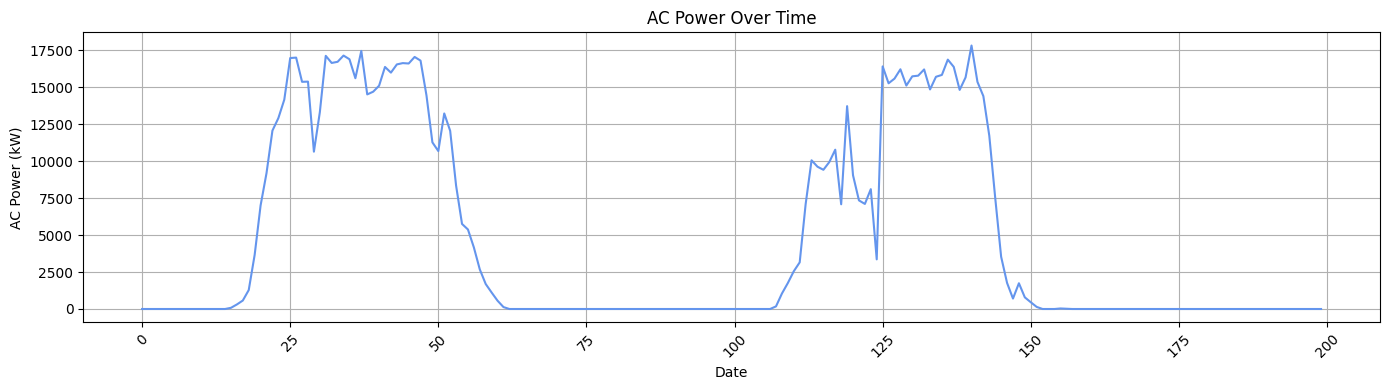

In [437]:
plt.figure(figsize=(14, 4))
plt.plot(np.array(df['AC_POWER'])[300:500],color="cornflowerblue")
plt.title('AC Power Over Time')
plt.xlabel('Date')
plt.ylabel('AC Power (kW)')
plt.grid(True)
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()

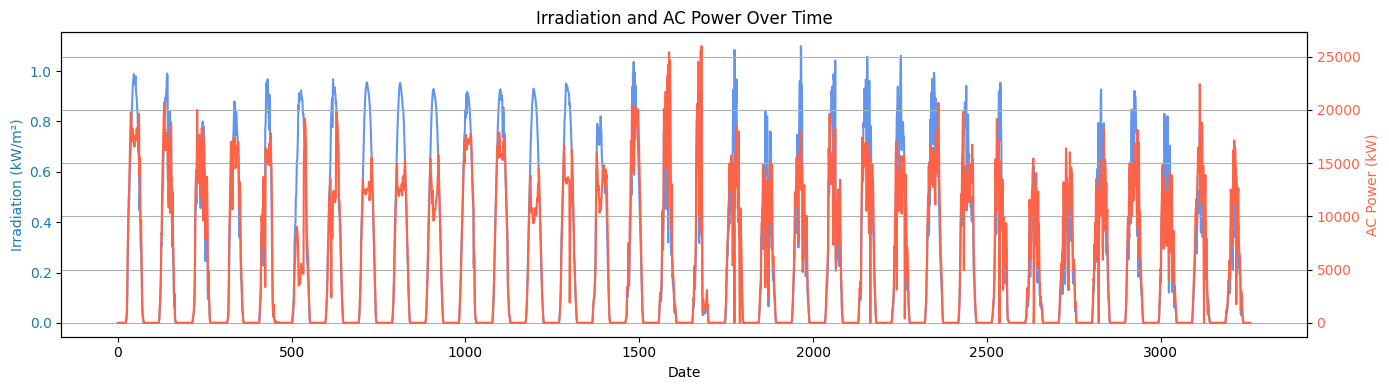

In [438]:
fig, ax1 = plt.subplots(figsize=(14, 4))

ax1.plot(np.array(df['IRRADIATION']), label='Irradiation',color="cornflowerblue")
ax1.set_xlabel('Date')
ax1.set_ylabel('Irradiation (kW/m²)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(np.array(df['AC_POWER']), color='tomato', label='AC Power')
ax2.set_ylabel('AC Power (kW)', color='tomato')
ax2.tick_params(axis='y', labelcolor='tomato')

plt.title('Irradiation and AC Power Over Time')
fig.tight_layout()
plt.xticks(rotation=45)
plt.grid(True)

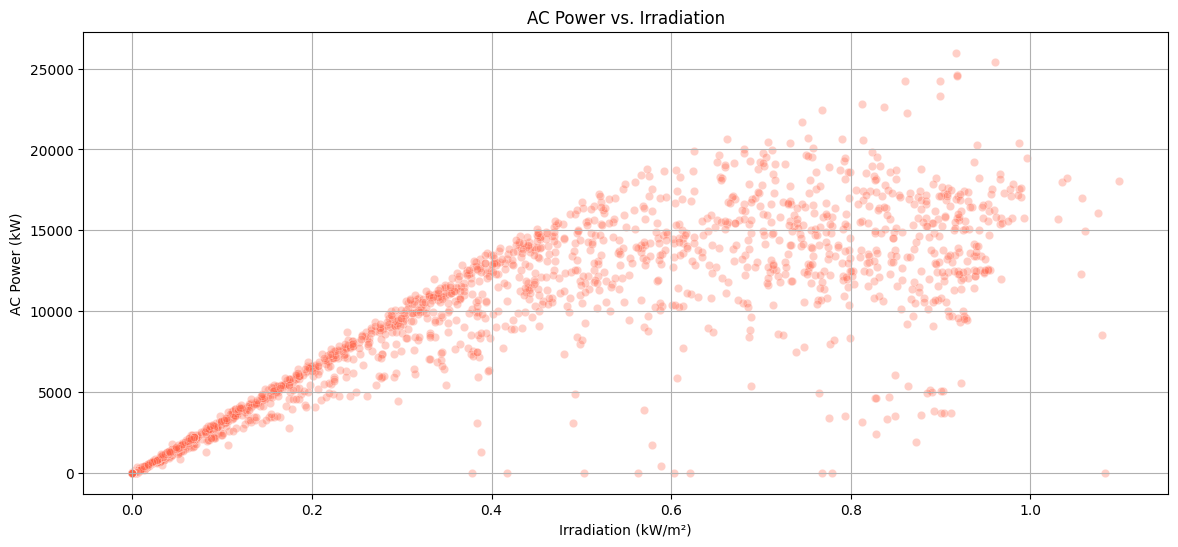

In [439]:
import seaborn as sns 

plt.figure(figsize=(14, 6))

sns.scatterplot(data=df, x='IRRADIATION', y='AC_POWER', alpha=0.3,color="tomato")

plt.title('AC Power vs. Irradiation')
plt.xlabel('Irradiation (kW/m²)')
plt.ylabel('AC Power (kW)')
plt.grid(True)
plt.show()

* Uma etapa muito importante antes de realizar o treinamento de qualquer modelo de regressão consiste na análise da matriz de correlação, a qual mostra a correlação entre as variáveis. Nesse contexto, desejamos que nossas features apresentem baixa correlação, ou seja, baixa colinearidade.

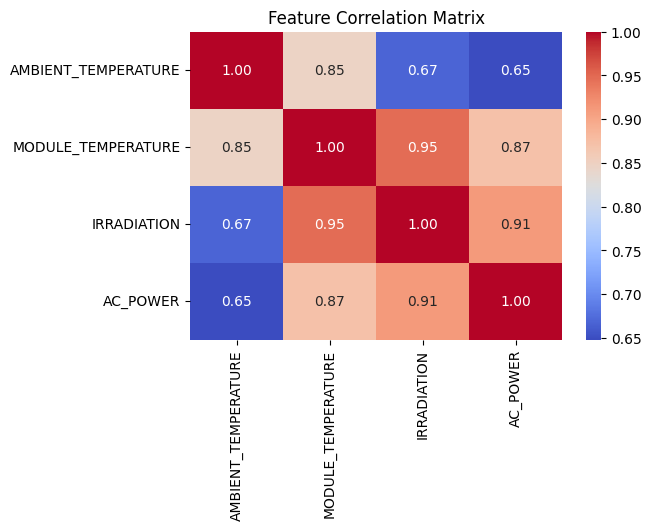

In [440]:
correlation_columns = ['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', 'AC_POWER']
corr_matrix = df[correlation_columns].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()

* As variáveis apresentam uma colinearidade considerável, o que certamente irá atraplhar o treinamento dos modelos de regressão.

In [441]:
df_features = df.drop(columns=["AC_POWER","DC_POWER","DAILY_YIELD","TOTAL_YIELD","MODULE_TEMPERATURE"])

In [442]:
X = np.array(df_features)
y = np.array(df["AC_POWER"])

In [443]:
np.set_printoptions(precision=3, suppress=True, linewidth=120)
covariance_matrix = np.cov(X, rowvar=False)
print(covariance_matrix)

[[16.496  0.848]
 [ 0.848  0.098]]


In [444]:
cond_number = np.linalg.cond(covariance_matrix)
print(cond_number)

306.0091415902179


* `cond_number` representa o condicionamento da matriz de covariância, uma matriz bem condicionada apresenta valores entre 1 e 10.

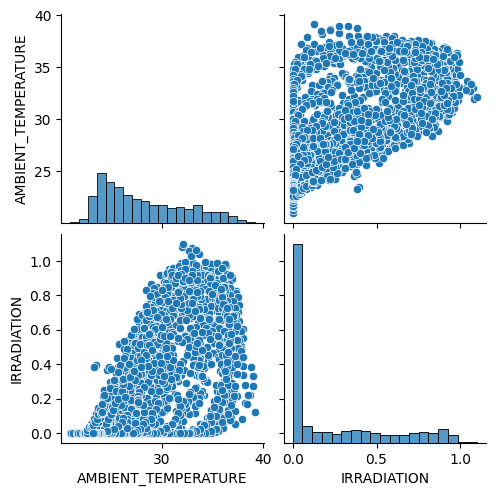

In [445]:
sns.pairplot(df_features)

In [446]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [447]:
np.set_printoptions(precision=3, suppress=True, linewidth=120)
covariance_matrix = np.cov(X_scaled, rowvar=False)
print(covariance_matrix)

[[1.    0.668]
 [0.668 1.   ]]


* Normalizando os dados verifica-se que o condicionamento da matriz melhora consideravelmente.

In [448]:
cond_number = np.linalg.cond(covariance_matrix)
print(cond_number)

5.017550490989252


In [449]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [450]:
def normalize(data):
    scaler = StandardScaler()
    scaler.fit(data)
    data_scaled = scaler.transform(data)
    return data_scaled,scaler

In [451]:
X_train_scaled,X_scaler = normalize(X_train)
X_test_scaled = X_scaler.transform(X_test)
joblib.dump(X_scaler, 'models/x_scaler.joblib')


y_train_scaled, y_scaler = normalize(y_train.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1))
joblib.dump(y_scaler, 'models/y_scaler.joblib')

['models/y_scaler.joblib']

In [452]:
from sklearn.metrics import root_mean_squared_error

def rmse(model,X,y_true):
    y_predicted = model.predict(X_scaler.transform(X))
    y_predicted = y_scaler.inverse_transform(y_predicted.reshape(-1, 1))
    return root_mean_squared_error(y_true, y_predicted)

In [453]:
def double_plot(first_serie,second_serie,title=""):
    fig, ax1 = plt.subplots(figsize=(12, 4))
    if title!="":
        plt.title(title)
    plt.plot(first_serie,label="Real",color="cornflowerblue")
    plt.plot(second_serie,label="Predicted",color="tomato")
    plt.legend()   

In [454]:
from sklearn.linear_model import LinearRegression
linear_reg = LinearRegression().fit(X_train_scaled, y_train_scaled)
y_predicted = linear_reg.predict(X_scaler.transform(X))
y_predicted = y_scaler.inverse_transform(y_predicted)

In [455]:
joblib.dump(linear_reg, 'models/linear_reg.joblib')

['models/linear_reg.joblib']

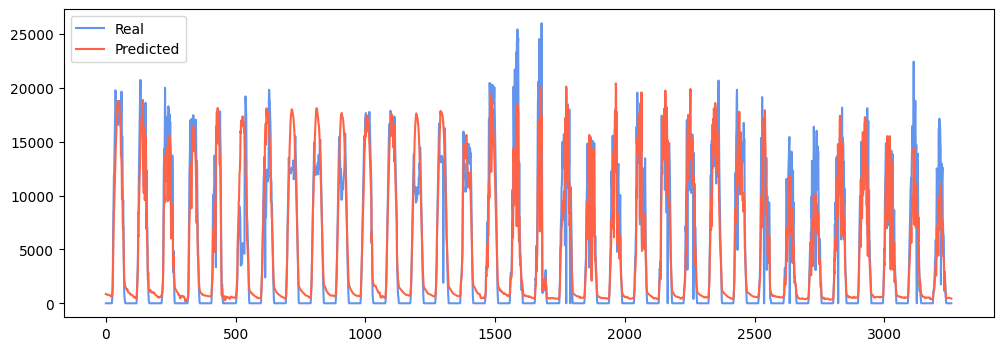

In [456]:
double_plot(y,y_predicted)

In [457]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

reg = MLPRegressor(random_state=1, max_iter=2000, tol=0.001)

param_grid = {
    'hidden_layer_sizes': [(50,),(64),(64,128),(64,32), (2,),(2,4),(2,4,8)],
    'activation': ['relu', 'tanh','identity'],
    'solver': ['adam', 'lbfgs'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive']
}

grid = GridSearchCV(
    estimator=reg,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train_scaled, y_train_scaled.ravel())

print(grid.best_params_)
print(-grid.best_score_)


Fitting 5 folds for each of 252 candidates, totalling 1260 fits
{'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (64, 128), 'learning_rate': 'constant', 'solver': 'lbfgs'}
0.10116504575066365


In [458]:
mlp_regressor = grid.best_estimator_

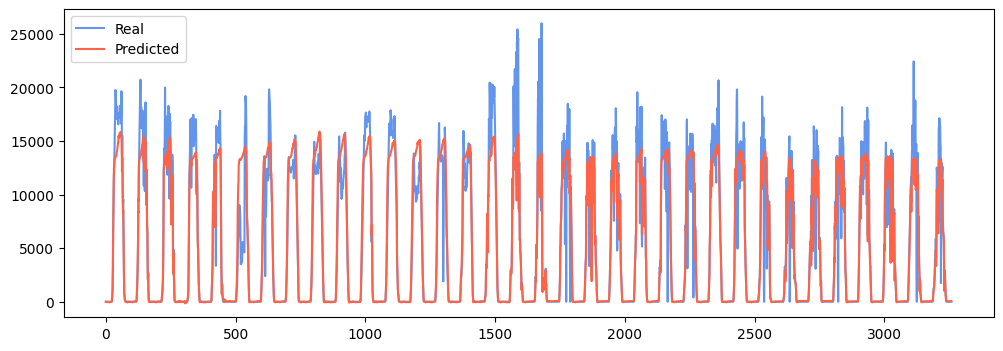

In [459]:
y_predicted = mlp_regressor.predict(X_scaler.transform(X))
y_predicted = y_scaler.inverse_transform(y_predicted.reshape(-1, 1))

double_plot(y,y_predicted)

In [460]:
joblib.dump(mlp_regressor, 'models/mlp_regressor.joblib')

['models/mlp_regressor.joblib']

In [461]:
rmse_linear_regression = rmse(linear_reg,X,y)
rmse_mlp_regressor  =  rmse(mlp_regressor,X,y)

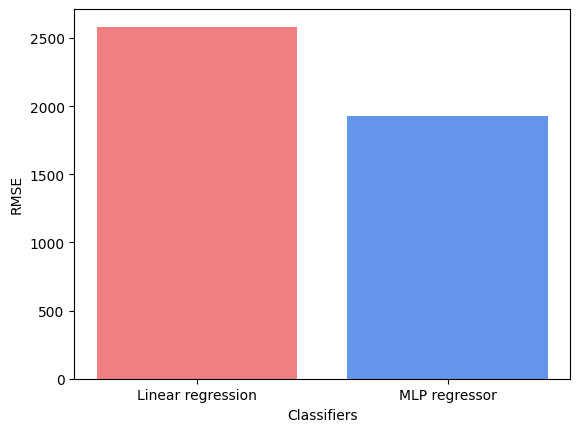

In [ ]:
plt.bar([1, 2], [rmse_linear_regression, rmse_mlp_regressor], color=["lightcoral", "cornflowerblue"])
plt.xlabel("Regressors")
plt.ylabel("RMSE")
plt.xticks([1, 2], ["Linear regression", "MLP regressor"])
plt.show()


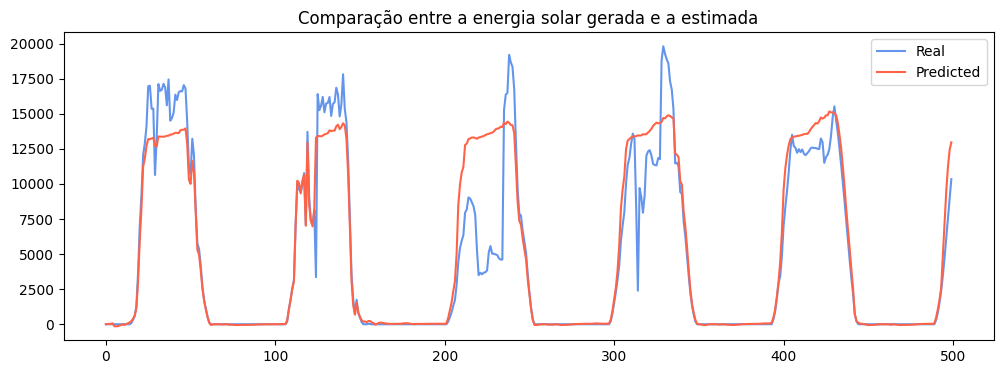

In [463]:
# mlp_regressor -> inteligência articial treinada

y_predicted = mlp_regressor.predict(X_scaler.transform(X))
y_predicted = y_scaler.inverse_transform(y_predicted.reshape(-1, 1))

double_plot(y[300:800],y_predicted[300:800],"Comparação entre a energia solar gerada e a estimada")